<i><b>Public-AI</b></i>
#### week 2. 협업 필터링
# Section 1. 협업 필터링의 기본 개념

유저에게 아이템을 추천할 때 사용할 수 있는 정보에는 (1) 유저 정보 (2) 아이템 정보 (3) 유저와 아이템 사이의 상호작용 정보가 있을 것입니다. 하지만 실무에서 유저와 아이템의 정확한 정보를 풍부하게 확보하는 것은 쉬운 일이 아닙니다. 이러한 문제를 극복하고자 연구하고 개발된 것이 유저와 아이템 사이의 상호작용 데이터를 이용해 유저간 혹은 아이템 간의 유사도를 계산하여 추천하는 협업 필터링(Collaborative Filtering)입니다. 이번 주차에는 추천 시스템의 핵심 알고리즘 중 하나인 협업 필터링의 기본 개념을 배우고, 상호작용 데이터를 이용해 유저 간 유사도를 구하는 다양한 방법을 알아보겠습니다. 

### _Objective_ 

* [문제 정의 : 어떤 아이템을 추천할 것인가?] 추천시스템 분야의 핵심 문제를 정의하고, 콘텐츠 정보 기반 추천의 한계를 알아봅니다.
* [기본 개념 : 협업 필터링과 유사도] 유저와 아이템 간의 상호작용 정보를 이용한 추천 시스템인 협업 필터링의 개념을 알아보고, 협업 필터링의 기본이 되는 유사도 알고리즘을 배웁니다.


In [1]:
# 필요한 라이브러리 가져오기
%matplotlib inline
import os
import numpy as np
import pandas as pd

from datetime import datetime

from tensorflow.keras.utils import get_file
from itertools import combinations

import matplotlib.pyplot as plt

## [ 실습 데이터 : MOVIE LENS 데이터 ]


### 1. 데이터 불러오기

In [2]:
ROOT_URL = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/datasets"

movie_path = get_file("movies.csv",ROOT_URL + "/movies.csv")
movie_df = pd.read_csv(movie_path)

genre_path = get_file("genres.csv",ROOT_URL + "/genres.csv")
genre_df = pd.read_csv(genre_path)

rating_path = get_file("ratings.csv",ROOT_URL + "/ratings.csv")
rating_df = pd.read_csv(rating_path)

### `movie_df` 확인하기

In [3]:
movie_df.sample(n=10)

,id,title,release_year
9898,32383,Finian's Rainbow,1968
18490,92156,Post Mortem,2010
15308,78081,Delusions of Grandeur (La folie des grandeurs),1971
12405,57538,Over Her Dead Body,2008
10607,40851,Zathura,2005
25416,120216,Sansa,2003
21250,103439,"Thieves, The (Dodookdeul)",2012
17965,90114,I Dream Too Much,1935
1390,1424,Inside,1996
14913,74677,"Yes Men Fix the World, The",2009


### `genre_df` 확인하기

In [4]:
genre_df.sample(n=10)

,movie_id,genre
11444,5856,Romance
7218,3667,Action
23394,48198,Drama
47047,110818,Comedy
32429,79195,Romance
53438,128488,Thriller
9923,5064,Drama
4219,2124,Comedy
51139,120276,Documentary
26306,59366,Romance


### `rating_df` 확인하기

In [5]:
rating_df.sample(n=10)

,user_id,movie_id,rating,rated_at
4359278,29719,4642,1.0,1369689841
11267115,77804,3354,3.0,1024376983
7426750,51233,648,5.0,1131663139
8945985,61839,440,3.0,974712527
18334226,126883,2150,3.0,1020010436
4177138,28460,1197,5.0,939025641
2437717,16490,2268,5.0,945068270
11465619,79175,1237,3.0,1144104425
14448481,99809,1307,5.0,985738090
13802972,95349,2268,4.0,1177533761


# \[ 문제 정의 : 어떤 아이템을 추천할 것인가?\]
---

어떠한 유저가 "One Day"라는 영화를 재밌게 보고 나와서, "One Day"와 유사한 영화를 찾고 있다고 해봅시다.

## 1. 오늘의 주제

> "One Day"를 재미있게 본 사람에게 어떤 영화를 추천할까? 


영화 One day는 앤 해서웨이가 주연으로 나오는 아름다운 로맨스 드라마 영화입니다. 영화를 보고난 후 어떤 고객이 이와 비슷하게 여운이 깊게 남는 영화를 찾고 있다고 합시다. 이 고객에게는 어떤 영화를 추천해주는 것이 좋을까요? 

<img src="https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F2727B44558972A7E04" width="150">


## 2. 첫번째 해결방법, "장르"를 기준으로 추천하기 : 콘텐츠 정보 기반 추천의 한계

고객이 선호하는 아이템(혹은 콘텐츠)과 유사한 아이템을 찾는 가장 간단한 방법은 아이템의 정보를 이용하는 것입니다. 영화로 치면 영화의 장르 정보를 이용하여 이를 기준으로 추천할 영화를 찾는 것이죠. 동일한 장르를 가지는 영화를 찾아보고, 이를 기준으로 영화를 추천해보겠습니다.

### (1) `one day`에 대한 장르 정보 가져오기
영화의 장르 정보는 `genres` 에서 확인할 수 있는데, `genres`는 영화 제목으로 조회할 수는 없고 `movie_id`를 이용해 조회할 수 있습니다. `movies` 테이블에서 아이디 값을 확인한 후, 이를 이용해 조회해봅시다.

In [6]:
# 위 영화'One Day'에 대한 정보 가져오기
oneday_movie_df = movie_df[movie_df.title == 'One Day']

# 'One Day' 영화에 대한 Genre 정보 가져오기
oneday_id = oneday_movie_df.id.iloc[0]
genre_df[genre_df.movie_id == oneday_id]

,movie_id,genre
36207,88179,Drama
36208,88179,Romance


### (2) 영화 별 장르 집합 구성하기

하나의 영화에는 다양한 장르가 결합되어 있습니다. 각 영화별로 어떠한 장르 속성이 존재하는지를 파악하기 위해, 영화 정보와 장르 정보를 모두 가져와 분석하도록 하겠습니다.

In [7]:
# 각 영화별로 장르를 집합으로 묶어주세요
genreset_per_movie = (
    genre_df
    .groupby('movie_id')
    ['genre']
    .apply(set))

genreset_per_movie.head(5)

movie_id
1    {Adventure, Children, Comedy, Fantasy, Animation}
2                       {Fantasy, Adventure, Children}
3                                    {Comedy, Romance}
4                             {Comedy, Drama, Romance}
5                                             {Comedy}
Name: genre, dtype: object

#### Oneday 영화의 장르 구성 가져오기

In [8]:
oneday_id = 88179
oneday_genreset = genreset_per_movie[oneday_id]
oneday_genreset

{'Drama', 'Romance'}

#### OneDay와 동일한 장르 구성을 가지고 있는 영화 가져오기

In [9]:
same_genre_movie_ids = (
    genreset_per_movie
    [genreset_per_movie == oneday_genreset]
    .index)

same_genre_movie_ids

Int64Index([    17,     25,     28,     35,     46,     49,     74,     83,
                85,    105,
            ...
            128688, 129032, 129788, 129841, 129857, 129947, 130388, 130396,
            130746, 131162],
           dtype='int64', name='movie_id', length=1075)

In [10]:
movie_df[movie_df.id.isin(same_genre_movie_ids)].sample(5)

,id,title,release_year
20633,101156,This Movie Is Broken,2010
10624,41094,Brides (Nyfes),2004
11582,50589,Trilogy: The Weeping Meadow (Trilogia: To liva...,2004
17912,89908,Someone I Loved (Je l'aimais),2009
4938,5034,"Truly, Madly, Deeply",1991


### (3) 콘텐츠(장르) 기반 추천의 한계 

이 영화 중에서는 One Day와 같이 한 커플의 만남에서 이별까지 다루는 서정적인 작품도 있을 것이고, 좀 더 치정극에 가까운 영화도 있을 겁니다. 같은 장르로 분류되기는 하지만, 위의 1075개 중에서도 One Day를 본 사람이 좋아할 만한 작품은 따로 존재할 것입니다. 또한 위 리스트에는 없지만, One Day를 좋아했던 사람들이라면 **이터널 선샤인**이라는 영화도 충분히 추천할만합니다. 테이블을 확인해보면 이터널 선샤인은 {Drama, Romance, Sci-Fi} 장르를 가지고 있어서 위의 방식으로 추천 영화 리스트를 뽑았을 땐 나오지 않았습니다.



이렇듯 콘텐츠 정보를 기반한 추천에서 콘텐츠 정보가 충분하지 않다면 위와 같이 적절한 추천을 수행하기가 어려워집니다. 콘텐츠 정보를 좀 더 모으는 방법, 예를 들면 장르를 세분화 한다던지, 감독 배우 등의 정보도 활용하는 방향도 있지만 이러한 작업들은 정보를 수집하고 정제하는 데 비용이 크게 듭니다. 이렇게 콘텐츠 정보를 활용하여 추천하는 방식에서 벗어나, 고객들의 상호작용 정보를 바탕으로 영화를 추천하는 방식으로 문제를 해결해보고자 합니다.

In [11]:
eternal_movie_id = 7361

display(movie_df[movie_df.title == 'Eternal Sunshine of the Spotless Mind'])
genre_df[genre_df.movie_id==eternal_movie_id]

,id,title,release_year
7249,7361,Eternal Sunshine of the Spotless Mind,2004


,movie_id,genre
14445,7361,Drama
14446,7361,Romance
14447,7361,Sci-Fi


# \[ 기본 개념 : 협업 필터링과 유사도\]
----

앞서 다룬 장르를 활용한 추천은 영화의 콘텐츠 정보를 활용하여 추천하는 일종의 콘텐츠 기반 필터링(Content-based Filtering)에 속하는 알고리즘입니다. 이와 다르게 협업 필터링(Collaborative Filtering)은 유저와 제품 사이의 상호작용 데이터를 바탕으로 유저에게 이전에 좋아했던 제품과 **유사한** 제품을 추천하거나(Item-Baed Collaborative Filtering), 유저의 취향과 **유사한** 취향을 가진 고객이 좋아한 제품을 추천하는 방식(User-Based Collaborative Filtering)을 말합니다. 협업 필터링의 핵심은 이러한 아이템 혹은 유저간의 "유사함"을 어떻게 정의하는가에 있습니다. 지금 시간에는 아이템 혹은 유저 간의 "유사함"을 어떻게 정의하는지 배우도록 하겠습니다.

## 1. Content-based Filtering과 Collaborative-Filtering

<img src="attachment:image.png" width="500">

유저 정보와 영화 정보와 같이, 속성 정보를 바탕으로 추천하는 알고리즘을 통틀어 Content-Based Filtering이라 하고, 유저와 영화 간의 상호작용, 예를 들어 구매/ 페이지 뷰 / 평점 등의 행동들을 바탕으로 추천하는 알고리즘을 Collaborative Filtering이라 합니다. 위에서 다룬 "장르 정보에 기반한 추천"은 대표적으로 Content-Based Filtering에 속합니다. 아이템(혹은 영화)가 아닌 유저의 정보를 바탕으로 Content-Based Filtering 기법으로 추천을 하다면, 유저의 성별이나 지역 정보를 이용할 수 있을 것입니다. <br>

Content-Based Filtering을 적용하기 위해서는 유저 정보와 영화 정보를 수집하고, 정제해야 하는 어려움이 있습니다. 매년 엄청난 수의 영화가 상영되는데, 각 영화의 특성을 일정한 기준으로 일관되게 입력하는 것은 어려운 일입니다. 유저의 정보 역시 개인정보 보호 정책에 따라 쉽게 수집할 수 없습니다. 이처럼 유저 정보와 아이템 정보를 수집하는 어려움 때문에 이를 대신하여 시스템에 축적되는 유저와 아이템 사이의 상호작용 데이터를 이용해, 유저의 취향과 아이템의 특성을 도출하고자 하는 방향으로 많은 연구 개발이 이루어졌습니다. Collaborative Filtering 알고리즘은 이를 대표하는 방법론입니다.

## 2. 영화 데이터 가져오기

Collaborative Filtering에서 핵심이 되는 유사도 개념을 배워보기 위해 5개의 영화를 우선 선정했습니다. 

|  `movie_id` | 영화이름 |
| ---    | --- |
| 8957   | 쏘우     |
| 2232   | 큐브     |
| 6323   | 아이덴티티 |
| 8638   | 비포선셋  |
| 215    | 비포선라이즈 |


비포선셋과 비포선라이즈는 One Day와 동일한 "Romance" & "Drama"이고, 그 외 쏘우 큐브 아이덴티티는 그와 다른 공포영화입니다.

In [12]:
target_movies = {
    8957: "Saw", 
    2232: "Cube", 
    6323: "Identity", 
    8638: "Before Sunset", 
    215: "Before Sunrise"}

#### 해당 영화에 대한 정보 가져오기

In [13]:
# 위 영화들에 대한 정보 가져오기
target_movie_df = movie_df[movie_df.id.isin(target_movies)]
target_genre_df = genre_df[genre_df.movie_id.isin(target_movies)]

pd.merge(target_movie_df, target_genre_df, left_on='id', right_on='movie_id')

,id,title,release_year,movie_id,genre
0,215,Before Sunrise,1995,215,Drama
1,215,Before Sunrise,1995,215,Romance
2,2232,Cube,1997,2232,Horror
3,2232,Cube,1997,2232,Mystery
4,2232,Cube,1997,2232,Sci-Fi
5,2232,Cube,1997,2232,Thriller
6,6323,Identity,2003,6323,Crime
7,6323,Identity,2003,6323,Horror
8,6323,Identity,2003,6323,Mystery
9,6323,Identity,2003,6323,Thriller


비포 선라이즈와 비포선셋은 "Drama","Romance" 장르에 속합니다. 반면 큐브, 아이덴티티, 쏘우 작품은 "Horror","Mystery","Thriller"등의 장르로 분류됩니다. 위 영화들에 대한 선호도 정보, 즉 리뷰에 남겨진 평점 정보를 가져오도록 하겠습니다.

In [14]:
target_rating_df = rating_df[rating_df.movie_id.isin(target_movies)]

# rating_df의 movie_id를 알아볼 수 있는 영화제목으로 변경
target_rating_df.loc[:,"title"] = target_rating_df.movie_id.map(target_movies)

target_rating_df.sample(5)

/Users/ksj/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ksj/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,user_id,movie_id,rating,rated_at,title
64064,451,8638,4.0,1223374070,Before Sunset
105103,735,215,4.0,1420396905,Before Sunrise
13791894,95294,8957,3.0,1296521664,Saw
6348114,43569,2232,3.0,1143264196,Cube
3663602,24952,8638,3.0,1279759151,Before Sunset


Collaborative Filtering은 

> "A"를 선호한 사람은 "B"도 선호하더라

식의 관계를 파악해야 합니다. 우선 우리는 해당영화를 모두 보고 평점을 내린 사람들의 정보를 가져오도록 하겠습니다.

In [15]:
# 유저 별 몇 개의 영화를 봤는지를 셈
counts_per_user = (
    target_rating_df
    .groupby('user_id')
    ['movie_id']
    .apply(lambda x : len(x))
)

all_seen_user_ids = (
    counts_per_user[counts_per_user==5]
    .index)

all_seen_rating_df = (
    target_rating_df
    [target_rating_df.user_id.isin(all_seen_user_ids)])

all_seen_rating_df.sample(5)

,user_id,movie_id,rating,rated_at,title
19152850,132509,215,3.5,1330784276,Before Sunrise
11338956,78308,2232,2.5,1111720958,Cube
17871812,123601,215,5.0,1118875924,Before Sunrise
2820723,19107,6323,4.0,1112410609,Identity
12363386,85422,215,3.0,1409861995,Before Sunrise


유저가 Before Sunrise, Before Sunset, Cube, Identity, Saw에 대해 평가한 점수를 바탕으로 
유저 별로 각 영화를 어떻게 평가헀는지 알기 위해서 `user_id`를 인덱스로, `title`를 칼럼으로 하는 피벗테이블을 구성합니다. 

In [16]:
ui_matrix = (
    all_seen_rating_df
    .pivot_table(values='rating',
                 index='user_id',
                 columns='title'))

ui_matrix

title,Before Sunrise,Before Sunset,Cube,Identity,Saw
user_id,,,,,
982,3.5,4.0,3.5,3.0,3.0
1165,4.5,4.0,4.0,2.5,2.5
1288,4.0,3.5,3.5,3.0,4.0
2650,4.0,4.0,3.0,4.0,4.5
2669,4.0,4.0,3.5,4.0,3.5
...,...,...,...,...,...
133329,5.0,4.5,5.0,3.0,4.0
134290,4.0,4.5,4.0,3.0,3.5
135071,3.5,3.5,3.5,3.5,3.5


### (3) 유저와 영화의 편향 제거하기

평점 데이터는 숫자 그대로 해석하게 되면 오류가 발생할 수 있습니다. 가령 비포 선라이즈를 4점으로 평가한 두 유저가 무작정 유사하다고 평가할 수는 없습니다.
같은 4점이라고 해도 어떤 유저는 4점이면 최고의 극찬을 한 것일 수도 있고, 어떤 유저는 보통 4점은 주기 때문에 그다지 좋게 평가한 것이 아닐 수도 있기 때문입니다. 영화도 마찬가지로 영화 자체의 완성도로 인해 점수를 높게 받은 경우가 있고 적게 받은 경우가 있습니다. 고객의 성향을 잘 드러내기 위해서는 유저나 영화에 따른 편향을 제거해야 합니다. 

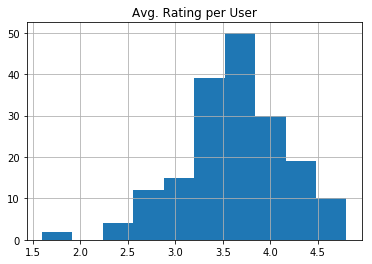

In [17]:
plt.title('Avg. Rating per User')
ui_matrix.mean(axis=1).hist()
plt.show()

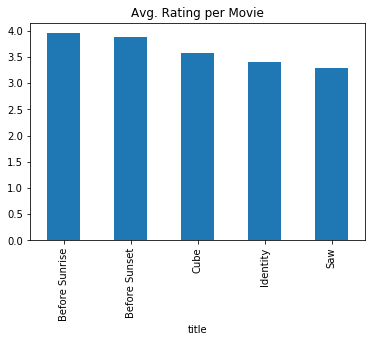

In [18]:
plt.title('Avg. Rating per Movie')
ui_matrix.mean(axis=0).plot(kind='bar')
plt.show()

각 유저의 평균 평점에서 전체 평균을 빼주면 각 유저의 편향을 알 수 있습니다. 마찬가지로 각 영화의 평균 평점에서 전체의 평균을 빼주면 영화의 편향을 계산할 수 있습니다. 

In [19]:
avg_rating = ui_matrix.mean().mean()

# 고객의 편향 계산하기
user_bias = ui_matrix.mean(axis=1) - avg_rating
# 아이템의 편향 계산하기
item_bias = ui_matrix.mean(axis=0) - avg_rating

이제 `ui_matrix`에서 유저의 편향과 영화의 편향을 빼면, 보정된 Matrix가 나옵니다.

In [20]:
adjusted_ui_matrix = (
    ui_matrix  # 유저 / 아이템 행렬에서
    .sub(user_bias,'rows') # 유저 편향을 제거하고
    .sub(item_bias,'columns') # 아이템 편향을 제거하여 보정하자
)

본래 `ui_matrix` 형태였던 데이터가 `adjusted_ui_matrix`로 바뀌었습니다. 

In [21]:
ui_matrix.head()

title,Before Sunrise,Before Sunset,Cube,Identity,Saw
user_id,,,,,
982,3.5,4.0,3.5,3.0,3.0
1165,4.5,4.0,4.0,2.5,2.5
1288,4.0,3.5,3.5,3.0,4.0
2650,4.0,4.0,3.0,4.0,4.5
2669,4.0,4.0,3.5,4.0,3.5


In [22]:
adjusted_ui_matrix.head()

title,Before Sunrise,Before Sunset,Cube,Identity,Saw
user_id,,,,,
982,3.392818,3.961878,3.765746,3.442541,3.544751
1165,4.292818,3.861878,4.165746,2.842541,2.944751
1288,3.692818,3.261878,3.565746,3.242541,4.344751
2650,3.392818,3.461878,2.765746,3.942541,4.544751
2669,3.492818,3.561878,3.365746,4.042541,3.644751


## 3. 유사도의 개념

이제 각 유저가 영화에 대해 남긴 평점을 이용해 유저끼리 얼마나 비슷한지 알아봐야 합니다. 두 유저가 비슷하다는 건 어떻게 알 수 있을까요? 영화에 대한 평가가 비슷하면 유사한 취향을 가졌다고 볼 수 있을 것입니다. 영화에 대한 평점이 비슷하다는 것은 어떻게 알 수 있을까요? 먼저, 영화별로 매긴 별점을 빼보았는데 값의 차이가 적다면(= 거리가 가깝다면) 두 사람의 영화 취향이 비슷하다고 볼 수 있을 것입니다. 혹은 서로 긍정적으로 평가한 영화와 부정적으로 평가한 영화가 같다면(= 방향성이 비슷하다면) 두 사람의 영화 취향이 비슷하다고 볼 수 있을 것입니다. <br>

유사도를 계산하는 알고리즘은 다양한 분야에서 사용되는데, 기본적으로는 다음 세가지 지표가 많이 사용됩니다. 
- 거리를 활용한 유사도: 맨하탄 거리 유사도, 유클리디안 거리 유사도
- 방향성을 이용한 유사도 : 코사인 유사도

이외에도 유사도를 설정하는 방법은 다양합니다. 분야마다 적합한 유사도가 따로 존재합니다. 앞서 만든 편향이 제거된 평점 데이터에 유사도 알고리즘을 적용하여 계산해본다면 어떻게 해야 할까요? 이에 대한 이해를 돕기 위해 아래의 예시를 살펴보도록 하겠습니다. 거리 및 방향성을 이용한 유사도는 2차원 그래프에 그려 시각화하면 이해하기 쉽습니다. 2차원에 시각화하기 위해 예시로 Before Sunrise와 Saw 두 영화를 모두 본 사람에 한해서 무작위로 5명을 추출하였습니다.

In [23]:
sample_cases = (
    adjusted_ui_matrix
    [["Before Sunrise","Saw"]]
    .dropna()
    .sample(n=5, random_state=2)
).copy()
sample_cases

title,Before Sunrise,Saw
user_id,,
47409,4.392818,4.544751
30123,3.192818,4.344751
6881,3.492818,3.144751
125794,3.992818,2.644751
120133,3.792818,3.444751


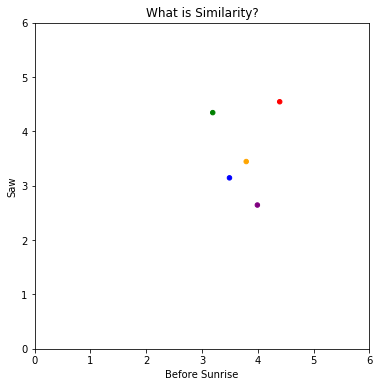

In [24]:
ax = sample_cases.plot(
    kind='scatter', x='Before Sunrise', y='Saw',
    c=['red','green','blue','purple','orange'],
    xlim=[0, 5.5], ylim=[0, 5.5], figsize=(6,6))

sample_cases.index = ['red','green','blue','purple','orange']
plt.title("What is Similarity?")
plt.xticks([0,1,2,3,4,5,6])
plt.yticks([0,1,2,3,4,5,6])
plt.show()

여기서 우리는 노란색 유저를 봅시다. 노란색 유저와 가장 유사한 취향을 가졌다고 판단되는 사람은 파란색 유저입니다. 직관적으로 보았을 때, 점의 위치가 비슷하다는 것은 Saw에 대한 선호도와 Before Sunrise에 대한 선호도가 비슷하다고 판단되기 때문입니다. 그렇다면 그 다음으로 노란색 유저와 **유사한** 취향을 가진 유저는 누구일까요?

1. 보라색
2. 빨간색
3. 초록색

이에 대한 답은 사실 Case-By-Case 입니다. 거리를 기준으로 **유사함**을 생각한다면, 우리는 가장 먼저 가깝다고 생각할 수 있는 것은 보라색 유저입니다. 근데 조금 다르게 해석해 볼 수 있습니다. 보라색 유저의 취향은 "saw"보다 "Before Sunrise"와 같은 로맨스 물을 더 좋아하는 취향으로 비추어 집니다. 그러면 우리는 단순히 거리로 해석하는 것이 아니라 아래와 같이, 각도를 기준으로 판단할 수 있습니다. 

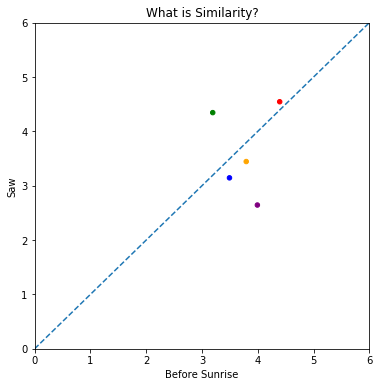

In [25]:
ax = sample_cases.plot(kind='scatter',
                  x='Before Sunrise',
                  y='Saw',
                  c=['red','green','blue','purple','orange'],
                  xlim=[0, 5.5],
                  ylim=[0, 5.5],
                  figsize=(6,6))

sample_cases.index = ['red','green','blue','purple','orange']
plt.plot([0,6],[0,6],'--')
plt.title("What is Similarity?")
plt.xticks([0,1,2,3,4,5,6])
plt.yticks([0,1,2,3,4,5,6])
plt.show()

주황색과 빨간색은 파란 점선을 기준으로 비슷한 위치에 분포하고 있습니다. 이 의미는 주황색 유저와 빨간색 유저가 Saw와 Before Sunrise에 대해서는 비교적 비슷하게 좋아하지만, 보라색 유저는 비포 선라이즈는 좋아하는 반면 쏘우는 그저 그렇게 생각한다고 볼 수 있습니다. 이렇듯 거리나 각도로 유사도를 판단할 수 있으며, 도메인마다 그 의미가 다를 수 있습니다. 이제 유사도를 직접 계산해 취향의 유사함을 수치로 구해보도록 하겠습니다.

### (1) 거리($L_p norm$)를 활용한 유사도 계산

거리 유사도 계산 방법에는 (1) 맨해튼 거리 유사도 식과 (2) 유클리디안 거리 유사도 식이 있습니다. 각각에 대해 알아봅시다.

#### 맨해튼 거리 ($L_1\ Norm$)

맨해튼 거리는 뉴욕의 맨해튼의 거리 모양을 따서 지은 이름으로, L1 노름(Norm)이라고도 부릅니다. 맨바둑판에서 어떤 지점A에서 지점B까지를 대각선 없이 가는 거리를 측정한다고 했을 때, 그 방법으로 거리를 구하는 것이 맨하튼 거리입니다. 이를 수식으로 표현하면 아래와 같습니다.
$$
\mathbf{dist(X,Y) = \sum_{i=1}^n(|x_i - y_i|)}
$$

거리가 멀수록 유사도는 낮아져야 하므로, 맨하탄 거리값을 활용하여 아래와 같이 맨하탄 거리 유사도를 계산합니다.
$$
\mathbf{sim(X,Y) = \frac{1}{1+dist(X,Y)}}
$$

In [26]:
def l1_distance(x, y):
    return np.sum(np.abs(x - y))

앞서 구해놓은 `sample_cases`에서 두 유저씩 뽑아 pair를 만든 후, 각 페어의 맨하튼 거리를 구해보겠습니다.

In [27]:
for (c1_name, c1_df), (c2_name, c2_df) in combinations(sample_cases.iterrows(), 2):
    dist = l1_distance(c1_df.values, c2_df.values)
    print(f"{c1_name:>6}과 {c2_name:>6}의 맨해튼 거리  : {dist:.3f}")

   red과  green의 맨해튼 거리  : 1.400
   red과   blue의 맨해튼 거리  : 2.300
   red과 purple의 맨해튼 거리  : 2.300
   red과 orange의 맨해튼 거리  : 1.700
 green과   blue의 맨해튼 거리  : 1.500
 green과 purple의 맨해튼 거리  : 2.500
 green과 orange의 맨해튼 거리  : 1.500
  blue과 purple의 맨해튼 거리  : 1.000
  blue과 orange의 맨해튼 거리  : 0.600
purple과 orange의 맨해튼 거리  : 1.000


거리를 사용하여 유사도를 구해보겠습니다.

In [28]:
for (c1_name, c1_df), (c2_name, c2_df) in combinations(sample_cases.iterrows(),2):
    dist = l1_distance(c1_df.values, c2_df.values)
    sim = 1/(1+dist)    
    print(f"{c1_name:>6}과 {c2_name:>6}의 맨해튼 유사도 : {sim:.3f}")    

   red과  green의 맨해튼 유사도 : 0.417
   red과   blue의 맨해튼 유사도 : 0.303
   red과 purple의 맨해튼 유사도 : 0.303
   red과 orange의 맨해튼 유사도 : 0.370
 green과   blue의 맨해튼 유사도 : 0.400
 green과 purple의 맨해튼 유사도 : 0.286
 green과 orange의 맨해튼 유사도 : 0.400
  blue과 purple의 맨해튼 유사도 : 0.500
  blue과 orange의 맨해튼 유사도 : 0.625
purple과 orange의 맨해튼 유사도 : 0.500


맨해튼 거리를 기준으로 하였을 때, 보라색와 주황색의 유사도는 빨간색와 주황색의 유사도보다 훨씬 높은 수치를 보여줍니다. 

#### 유클리디안 거리 ($L_2\ Norm$)

유클리디안 거리는 직각삼각형에서 90도 각의 대변의 길이를 구하는 공식을 사용해 두 점 사이의 거리를 구하는 방법입니다. 거리값을 이용해 유사도를 구하는 식은 맨하튼 거리 유사도의 방식과 동일합니다.

$$
\mathbf{Dist(X,Y) = \sqrt{\sum_{i=1}^{n}(x_i-y_i)^2}}
$$

In [29]:
def l2_distance(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [30]:
for (c1_name, c1_df), (c2_name, c2_df) in combinations(sample_cases.iterrows(),2):
    dist = l2_distance(c1_df.values, c2_df.values)
    sim = 1/(1+dist)
    print(f"{c1_name:>6}과 {c2_name:>6}의 유클리드 거리  : {dist:.3f}")   

   red과  green의 유클리드 거리  : 1.217
   red과   blue의 유클리드 거리  : 1.664
   red과 purple의 유클리드 거리  : 1.942
   red과 orange의 유클리드 거리  : 1.253
 green과   blue의 유클리드 거리  : 1.237
 green과 purple의 유클리드 거리  : 1.879
 green과 orange의 유클리드 거리  : 1.082
  blue과 purple의 유클리드 거리  : 0.707
  blue과 orange의 유클리드 거리  : 0.424
purple과 orange의 유클리드 거리  : 0.825


In [31]:
for (c1_name, c1_df), (c2_name, c2_df) in combinations(sample_cases.iterrows(),2):
    dist = l2_distance(c1_df.values, c2_df.values)
    sim = 1/(1+dist)
    print(f"{c1_name:>6}과 {c2_name:>6}의 유클리드 유사도 : {sim:.3f}") 

   red과  green의 유클리드 유사도 : 0.451
   red과   blue의 유클리드 유사도 : 0.375
   red과 purple의 유클리드 유사도 : 0.340
   red과 orange의 유클리드 유사도 : 0.444
 green과   blue의 유클리드 유사도 : 0.447
 green과 purple의 유클리드 유사도 : 0.347
 green과 orange의 유클리드 유사도 : 0.480
  blue과 purple의 유클리드 유사도 : 0.586
  blue과 orange의 유클리드 유사도 : 0.702
purple과 orange의 유클리드 유사도 : 0.548


유클리디안 거리를 기준으로 하였을 때, 보라색와 주황색의 유사도는 빨간색와 주황색의 유사도보다 높게 나왓지만, 맨해튼 거리를 했을 때보다는 그 차이가 줄어들었습니다.
맨해튼 거리와 유클리디안 거리는 둘 다 거리의 차이를 통해 유사도를 계산하지만, **각 축의 차이를 더 반영해야 할 때에는 맨해튼 거리를, 전반적인 취향을 종합하여 반영해야 할때에는 유클리디안 거리를 활용합니다.** 좀 더 자세히 설명하면, 한 축이라도 큰 차이가 그 차이를 그대로 유사도가 먼 것으로 반영하겠다면 맨해튼 거리를 사용하여 유사도를 계산하면 됩니다. 반면, 유클리디안 거리를 이용하면 한 축을 기준으로는 차이가 많이 나지만 다른 축을 기준으로는 가까운 경우와 양쪽 축에서 모두 중간 정도 거리의 차이가 있는 경우의 유사도를 비슷하게 볼 것입니다. 

### (2) 방향성을 이용한 유사도 계산

코사인 유사도는 두 아이템 벡터의 각도가 얼마나 차이나는지를 계산하는 방식입니다. 각도 상으로 같은 선상에 있다면, 직선 거리는 멀더라도 유사하다고 보는 것이죠. 

$$
\mathbf{Cosine\_Similarity(X,Y) = \frac{\sum_{i=1}^{n}x_i y_i}{\sqrt{\sum_{i=1}^{n}x_i^2} \sqrt{\sum_{i=1}^{n}y_i^2}}}
$$

In [32]:
def cosine_similarity(x, y):
    return np.sum(x*y)/(np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2)))

In [33]:
for (c1_name, c1_df), (c2_name, c2_df) in combinations(sample_cases.iterrows(),2):
    sim = cosine_similarity(c1_df.values, c2_df.values)
    print(f"{c1_name:>6}과 {c2_name:>6}의 유사도 : {sim:.3f}")    

   red과  green의 유사도 : 0.991
   red과   blue의 유사도 : 0.998
   red과 purple의 유사도 : 0.976
   red과 orange의 유사도 : 0.998
 green과   blue의 유사도 : 0.979
 green과 purple의 유사도 : 0.939
 green과 orange의 유사도 : 0.980
  blue과 purple의 유사도 : 0.989
  blue과 orange의 유사도 : 1.000
purple과 orange의 유사도 : 0.988


결과를 볼까요? 거리를 이용한 유사도를 계산할 때와는 서로 다른 결과가 나왔습니다. 빨간색과 주황색의 유사도가 보라색와 주황색의 유사도보다 높게 나왔습니다. 앞서 그렸던 그래프를 다시 보면, 파란색 점선을 기준으로 빨간색과 주황색은 파란선 근처에 있지만, 보라색은 좀 떨어져 있습니다. 각 유저의 평점을 다시 봐볼까요?

In [34]:
sample_cases

title,Before Sunrise,Saw
red,4.392818,4.544751
green,3.192818,4.344751
blue,3.492818,3.144751
purple,3.992818,2.644751
orange,3.792818,3.444751


빨간 유저는 두 영화에 각각 4.39, 4.5 정도의 비슷한 수준의 평점을 주었고, 주황 유저는 두 영화에 각각 3.79, 3.4 정도의 비슷한 수준의 평점을 두었습니다. 코사인 유사도는 빨간색 유저와 주황색 유저가 Saw와 Before Sunrise를 좋아하는 수준이 비슷하다는 점을 이용해 유사도를 계산한 것입니다. 영화 취향에 대해 두 유저가 같은 방향성을 가지고 있다고 보는 것이죠. <br>
유사도 알고리즘은 이렇듯 유사함을 어떻게 정의하는가에 따라 서로 다른 수식을 적용해야 합니다. <올바른 유사도가 무엇인가?>에 대한 답은 늘 데이터에 따라 달라집니다. 일반적으로 현업 필터링에서 적용할 때에는 다양한 유사도 수식을 데이터에 적용해 의도했던 방향으로 순위가 매겨지거나, 결과가 도출되는지 확인해보고 유사도 수식을 결정하게 됩니다. 

----

### \[ Additional \]

유사도를 계산할 때, 피어슨 상관 계수도 자주 이용됩니다. 피어슨 상관 계수는 두 변수 간 선형 상관 관계를 계량화한 수치로, 
* +1 : 완벽한 양의 상관 관계
* 0 : 상관 관계가 전혀 없음
* -1 : 완벽한 음의 상관 관계

를 뜻합니다. 수식은 

$$
\mathbf{R(X,Y) = \frac{\sum_{i=1}^{n} (x_i-\bar{x}) (y_i-\bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2} \sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}}
$$

위 수식을 자세히 보면 Cosine Similarity와 닮아 있습니다. Cosine Similarity를 계산하기 전에 각 Vector을 평균 값으로 빼주는 작업이 들어가 있습니다. 그래서 구현은 아래와 같이 손쉽게 할 수 있습니다.

In [35]:
def pearson_coefficient(x, y):
    num = np.sum((x - x.mean()) * (y - y.mean()))
    denom = np.sqrt(np.sum((x-x.mean())**2)) * np.sqrt(np.sum((y-y.mean())**2))
    return num / denom

In [36]:
for (c1_name, c1_df), (c2_name, c2_df) in combinations(sample_cases.iterrows(),2):
    sim = pearson_coefficient(c1_df.values, c2_df.values)
    print(f"{c1_name:>6}과 {c2_name:>6}의 유사도 : {sim:.3f}")    

   red과  green의 유사도 : 1.000
   red과   blue의 유사도 : -1.000
   red과 purple의 유사도 : -1.000
   red과 orange의 유사도 : -1.000
 green과   blue의 유사도 : -1.000
 green과 purple의 유사도 : -1.000
 green과 orange의 유사도 : -1.000
  blue과 purple의 유사도 : 1.000
  blue과 orange의 유사도 : 1.000
purple과 orange의 유사도 : 1.000


현재 데이터는 "Saw"와 "Before Sunrise"로만 이루어져 있기 때문에, 피어슨 상관계수는 극단적으로 1과 -1로만 나타나게 됩니다.

#  

---

    Copyright(c) 2020 by Public AI. All rights reserved.
    Writen by PAI, SeonYoul Choi ( best10@publicai.co.kr )  last updated on 2020/06/06


---